# Cover Art

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import sympy as sm
from tqdm import tqdm
from itertools import product

# Import my own libraries
sys.path.append('./utils/')
from odeAnalysisUtils import rdModel_nsKill,Simulate_AT_FixedThreshold,\
                            GenerateATComparisonPlot,GenerateParameterDic,\
                            ProfileTreatmentStrategies

# Format plot
sns.set(style="white",
        font_scale=1.5,
        font="Serif",
        rc={'figure.figsize':(12,6)})

In [4]:
# Define the parameters
paramDic = {"rS":.027, "rR":.027, "cRS":1., "cSR":1.,"dD":1.5, 
            "k":1., "D":0, "theta":1, 'DMax':1.}
paramDic['dR'] = 0.*paramDic['rR']
paramDic['dS'] = 0.*paramDic['rS']
nTimePts = 100
dt = 1.
intervalLength = 1
perspectivesList = [(30,295),(45,-75),(85,-48),(58,-69),(86,-21),(20,161)]

# Define equations using sympy
varList = sm.symbols('s, r, rS, rR, cRS, cSR, dS, dR, k, dD, D', negative=False)
s, r, rS, rR, cRS, cSR, dS, dR, k, dD, D = varList
fS = rS*(1-s-cRS*r)*(1-dD*D)*s-dS*s
fR = (rR-dR-rR/k*(cSR*s+r))*r

A collage of phase planes from our paper were featured on the cover of the issue of Cancer Research in which our paper was published. Find below the code which was used to generate the mosaic of 3-D(!) phase planes.

## Simulation Code

In [3]:
def RunSimulations(initialTumourSize,sFrac,paramDic=paramDic,
                             t_end=1500,relToPopEq=False,finishAtProgression=True,
                             intervalLength=1.,nTimePts=100.):
    if relToPopEq: initialTumourSize *= (1-paramDic['dS']/paramDic['rS'])
    initialStateVec = [initialTumourSize*sFrac,initialTumourSize*(1-sFrac),0,paramDic['DMax']]
    initialStateVec[2] = paramDic['theta']*(initialStateVec[0] + initialStateVec[1])

    # Simulate
    resultsDf = Simulate_AT_FixedThreshold(modelFun=rdModel_nsKill,
                                           initialStateVec=initialStateVec,
                                           atThreshold=1.,intervalLength=t_end,
                                           paramDic=paramDic,
                                           t_end=t_end, t_eval=np.linspace(0,t_end,int(nTimePts)))
    ttp_ct = resultsDf.Time[resultsDf.V > 1.2*initialTumourSize].min()
    if finishAtProgression: 
        resultsDf_ct = resultsDf[resultsDf.Time<ttp_ct] if ttp_ct is not np.nan else resultsDf.copy()
    else:
        resultsDf_ct = resultsDf.copy()

    resultsDf = Simulate_AT_FixedThreshold(modelFun=rdModel_nsKill,
                                           initialStateVec=initialStateVec,
                                           atThreshold=.3,intervalLength=intervalLength,
                                           paramDic=paramDic,
                                           t_end=t_end, t_eval=np.linspace(0,t_end,int(nTimePts)))
    ttp_at = resultsDf.Time[resultsDf.V > 1.2*initialTumourSize].min()
    if finishAtProgression: 
        resultsDf_at = resultsDf[resultsDf.Time<ttp_at] if ttp_at is not np.nan else resultsDf.copy()
    else:
        resultsDf_at = resultsDf.copy()
    return (resultsDf_ct,resultsDf_at)

## Plots - Different Perspectives

<IPython.core.display.Javascript object>


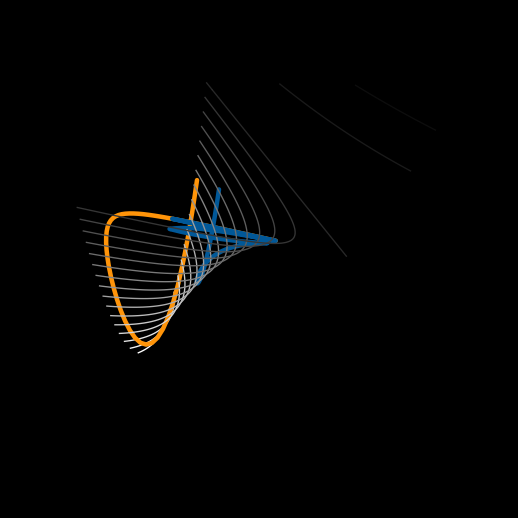

<IPython.core.display.Javascript object>


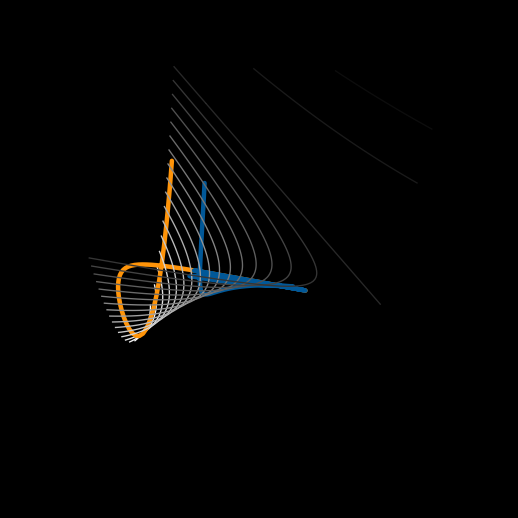

<IPython.core.display.Javascript object>


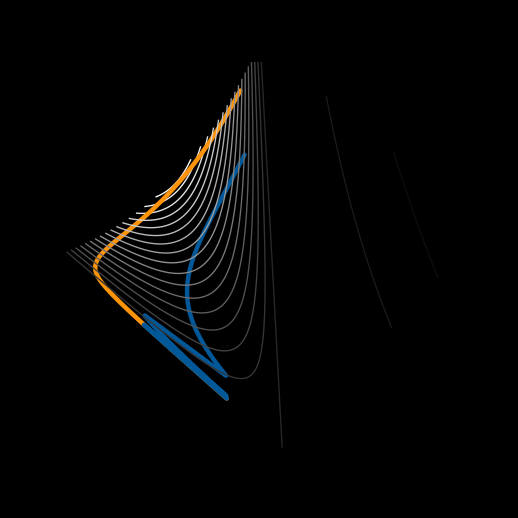

<IPython.core.display.Javascript object>


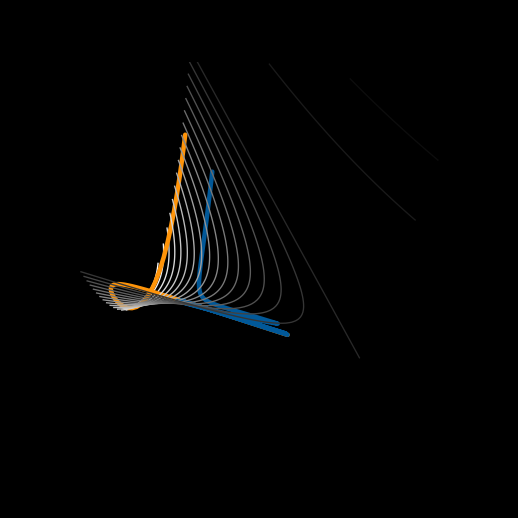

<IPython.core.display.Javascript object>


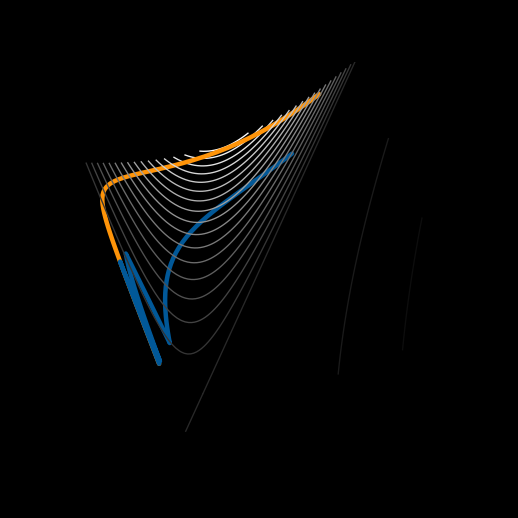

<IPython.core.display.Javascript object>


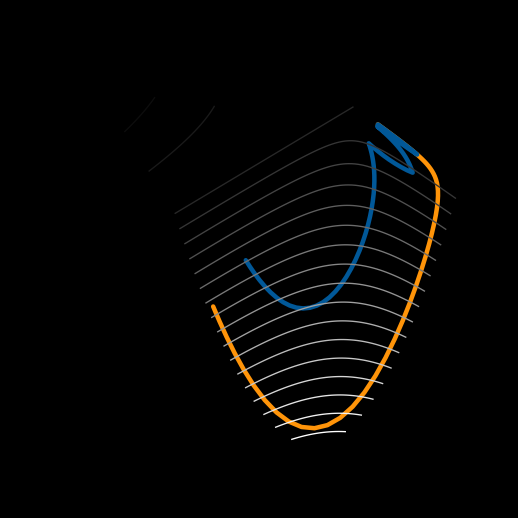

In [112]:
initialSize = 0.75
sFrac = 0.999
tEnd = 750
xlimVec = [0,1]
ylimVec = [0,1]
nPoints = 100
nLevels_overlay = 50
vmax=0.3

sVec = np.linspace(max(xlimVec[0],0), xlimVec[1], nPoints)
rVec = np.linspace(max(ylimVec[0],0), ylimVec[1], nPoints)

# Plot the vector-field
fS_lambidified = sm.lambdify(varList, fS)
FlowFun_X = lambda s, r, paramDic: fS_lambidified(
    *tuple([{"s": s, "r": r, **paramDic}[str(var)] for var in varList]))
fR_lambidified = sm.lambdify(varList, fR)
FlowFun_Y = lambda s, r, paramDic: fR_lambidified(
    *tuple([{"s": s, "r": r, **paramDic}[str(var)] for var in varList]))
X, Y = np.meshgrid(sVec, rVec)
U = FlowFun_X(X, Y, paramDic)/paramDic['rS']
V = FlowFun_Y(X, Y, paramDic)/paramDic['rS']
vMat = -V # Flip so that get a trough where resistant growth is fastest
vMat[vMat>0] *= 0.05

# %matplotlib notebook

for i, (elev, azim) in enumerate([(30,295),(45,-75),(85,-48),(58,-69),(86,-21),(20,161)]):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.contour3D(sVec, rVec, vMat, 25, cmap='binary')
    # ax.view_init(elev=30, azim=295)
    # ax.view_init(elev=45, azim=-75)
    # ax.view_init(elev=85, azim=-48)
    # ax.view_init(elev=58, azim=-69)
    # ax.view_init(elev=86, azim=-21)
#     ax.view_init(elev=20, azim=161)
    ax.view_init(elev=elev, azim=azim)
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    plt.axis('off')
    ax.grid(False) 
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.dist=7
    plt.show()

    # Data for a three-dimensional line
    # simulationResultsDf = RunSimulations(initialTumourSize=initialSize,sFrac=sFrac,paramDic=currParamDic,
    #                                  relToPopEq=False,t_end=tEnd)
    for treatmentId in range(2):
        col = '#FF9409' if treatmentId==0 else '#015898'
        zline = -FlowFun_Y(simulationResultsDf[treatmentId].S,simulationResultsDf[treatmentId].R,paramDic)/paramDic['rS'] #np.zeros_like(simulationResultsDf[treatmentId].S)
        ax.plot3D(simulationResultsDf[treatmentId].S,simulationResultsDf[treatmentId].R,zline,lw=5,
                    color=col,linestyle='-')
    plt.savefig("figures/coverArt_view%d.pdf"%i)

## Plots - Different Simulation Parameters

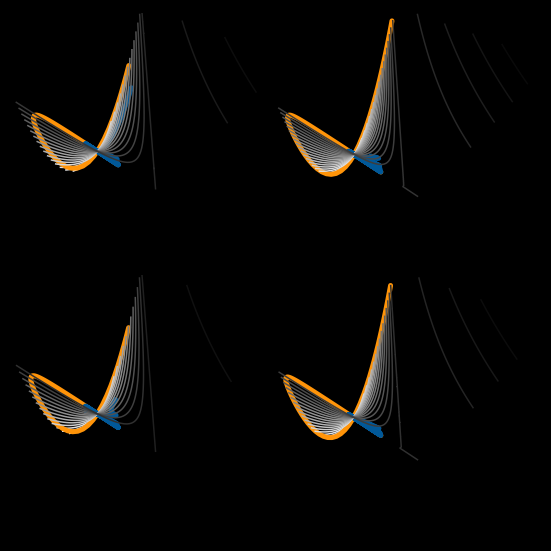

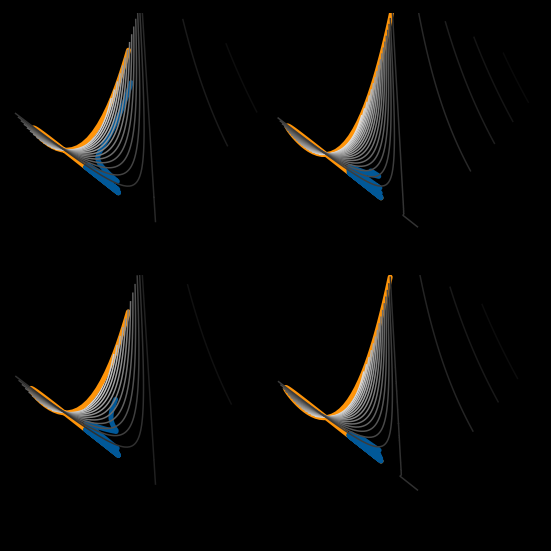

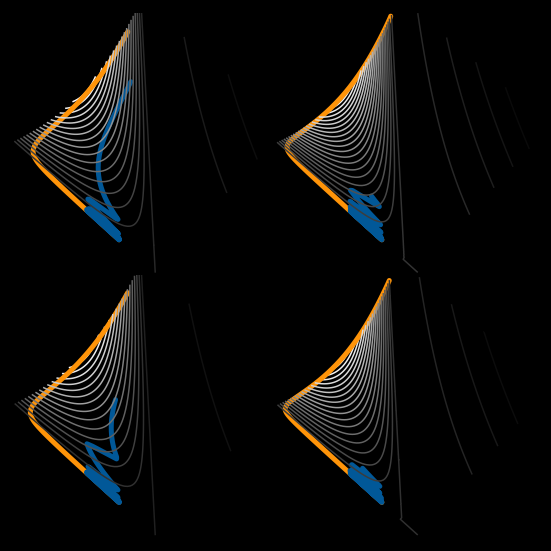

In [43]:
import matplotlib.gridspec as gridspec

initialSize = 0.75
sFrac = 0.999
rFrac = 1-sFrac
tEnd = 750
xlimVec = [0,1]
ylimVec = [0,1]
nPoints = 100
nLevels_overlay = 50
vmax=0.3

elev, azim = perspectivesList[2]

sVec = np.linspace(max(xlimVec[0],0), xlimVec[1], nPoints)
rVec = np.linspace(max(ylimVec[0],0), ylimVec[1], nPoints)

for k, (elev, axim) in enumerate(np.array(perspectivesList)[[1,3,4]]):
    fig = plt.figure(figsize=(8,8))
    i = 1
    for cost, turnover in product([0,0.1],[0,0.1]):
        # Set parameters
        _,currParamDic = GenerateParameterDic(initialSize=initialSize,rFrac=rFrac,
                                              cost=cost,turnover=turnover,paramDic=paramDic)
        # Plot the vector-field
        fS_lambidified = sm.lambdify(varList, fS)
        FlowFun_X = lambda s, r, currParamDic: fS_lambidified(
            *tuple([{"s": s, "r": r, **currParamDic}[str(var)] for var in varList]))
        fR_lambidified = sm.lambdify(varList, fR)
        FlowFun_Y = lambda s, r, currParamDic: fR_lambidified(
            *tuple([{"s": s, "r": r, **currParamDic}[str(var)] for var in varList]))
        X, Y = np.meshgrid(sVec, rVec)
        U = FlowFun_X(X, Y, currParamDic)/currParamDic['rS']
        V = FlowFun_Y(X, Y, currParamDic)/currParamDic['rS']
        vMat = -V # Flip so that get a trough where resistant growth is fastest
        vMat[vMat>0] *= 0.05

        # %matplotlib notebook

    #     fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(2, 2, i, projection='3d')
        ax.contour3D(sVec, rVec, vMat, 25, cmap='binary')
        ax.view_init(elev=elev, azim=azim)
        fig.set_facecolor('black')
        ax.set_facecolor('black')
        plt.axis('off')
        ax.grid(False) 
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
        ax.dist=7

        # Data for a three-dimensional line
        simulationResultsDf = RunSimulations(initialTumourSize=initialSize,sFrac=sFrac,paramDic=currParamDic,
                                         relToPopEq=False,t_end=tEnd)
        for treatmentId in range(2):
            col = '#FF9409' if treatmentId==0 else '#015898'
            zline = -FlowFun_Y(simulationResultsDf[treatmentId].S,simulationResultsDf[treatmentId].R,currParamDic)/currParamDic['rS'] #np.zeros_like(simulationResultsDf[treatmentId].S)
            ax.plot3D(simulationResultsDf[treatmentId].S,simulationResultsDf[treatmentId].R,zline,lw=5,
                        color=col,linestyle='-')
    #     plt.show()
        i += 1
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig("figures/coverArt_sweep_view%d.pdf"%k)